## LOAD MAP
------------------
http://wiki.ros.org/map_server#YAML_format
explanation of how ros map works

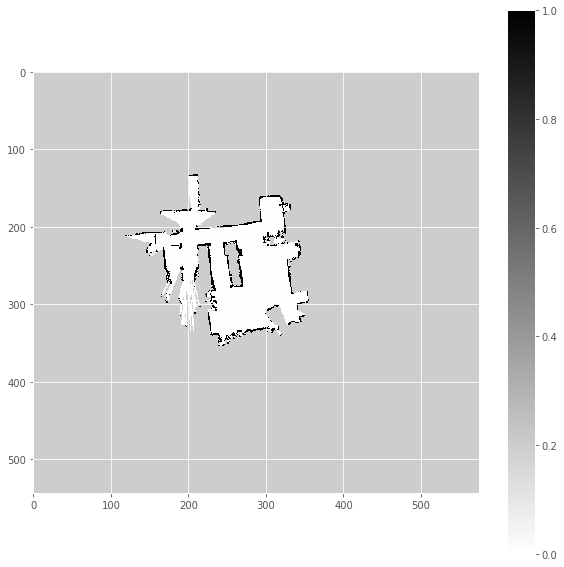

In [7]:
import re
import numpy
from matplotlib import pyplot as plt
plt.style.use('ggplot')

def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return (255-numpy.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width))))/255.0


# map_ = read_pgm("willow-2010-02-18-0.10.pgm", byteorder='<')
map_ = read_pgm("maps/test_map.pgm", byteorder='<')
plt.figure(figsize=(10,10))
plt.imshow(map_, plt.cm.binary)
plt.colorbar()
plt.show()

In [18]:
numpy.unique(map_)

array([0.        , 0.00392157, 0.05098039, 0.14509804, 0.19607843,
       1.        ])

## COMPUTE COSTMAP
--------------------
http://wiki.ros.org/costmap_2d
explanation of how ros map works

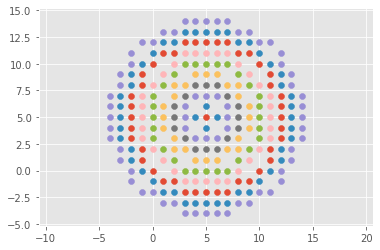

In [8]:
def circle(radius,center=(0,0)):
    '''
    Bresenham circle algorithm
    '''
    # init vars
    switch = 3 - (2 * radius)
    points = set() #set instead of list to avoid duplicates
    x = 0
    y = radius
    # first quarter/octant starts clockwise at 12 o'clock
    while x <= y:
        # first quarter first octant
        points.add((center[0]+x, center[1]-y))
        # first quarter 2nd octant
        points.add((center[0]+y, center[1]-x))
        # second quarter 3rd octant
        points.add((center[0]+y, center[1]+x))
        # second quarter 4.octant
        points.add((center[0]+x, center[1]+y))
        # third quarter 5.octant
        points.add((center[0]-x, center[1]+y))        
        # third quarter 6.octant
        points.add((center[0]-y, center[1]+x))
        # fourth quarter 7.octant
        points.add((center[0]-y, center[1]-x))
        # fourth quarter 8.octant
        points.add((center[0]-x, center[1]-y))
        if switch < 0:
            switch = switch + (4 * x) + 6
        else:
            switch = switch + (4 * (x - y)) + 10
            y = y - 1
        x = x + 1
    return points

plt.figure()
for rad in range(0,10):
    plt.scatter([a[0] for a in circle(rad,(5,5))],[a[1] for a in circle(rad,(5,5))])
    
plt.axis('equal')
plt.show()

find distace(radius from closest obstacle)

In [30]:
def take_np(arr,idx):
    out=[]
    for i in idx:
        out.append(arr[i[0],i[1]])
    return out

In [34]:
def distance(current_cell,npmap):
    dist=0
    cells=circle(dist,current_cell)
    cell_vals=take_np(npmap,list(cells))
    occ_tresh=0.9

    while all(val < occ_tresh for val in cell_vals):
        dist=dist+1
        cells=circle(dist,current_cell)
        cell_vals=take_np(npmap,list(cells))
    
    return dist

distance((200,200),map_)

8

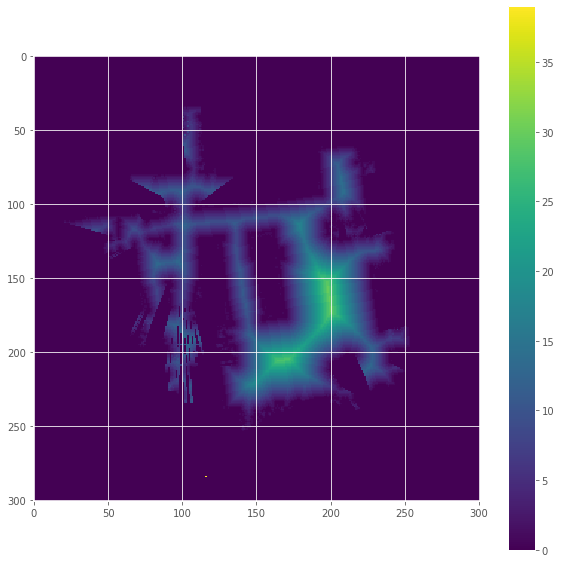

In [38]:
distance_map=numpy.zeros_like(map_)
free_thresh= 0.196
for x_idx in range(map_.shape[0]):
    for y_idx in range(map_.shape[1]):
        if map_[x_idx,y_idx]<free_thresh:
            distance_map[x_idx,y_idx]=distance((x_idx,y_idx),map_)
            
plt.figure(figsize=(10,10))
plt.imshow(distance_map[100:401,100:401])
plt.colorbar()
plt.show()

this map contains distances, it has to be converted to cost

In [45]:
def compute_cost(distance):
    
    resolution_=0.050000 #
    LETHAL_OBSTACLE=255 #
    INSCRIBED_INFLATED_OBSTACLE=254 #
    inscribed_radius_=0.3 #
    weight_=1
    
    cost = 0;
    if (distance == 0):
        cost = LETHAL_OBSTACLE
    elif (distance * resolution_ <= inscribed_radius_):
        cost = INSCRIBED_INFLATED_OBSTACLE
    else:
        #make sure cost falls off by Euclidean distance
        euclidean_distance = distance * resolution_;
        factor = numpy.exp(-1.0 * weight_ * (euclidean_distance - inscribed_radius_));
        cost = ((INSCRIBED_INFLATED_OBSTACLE - 1) * factor);
        
    return cost

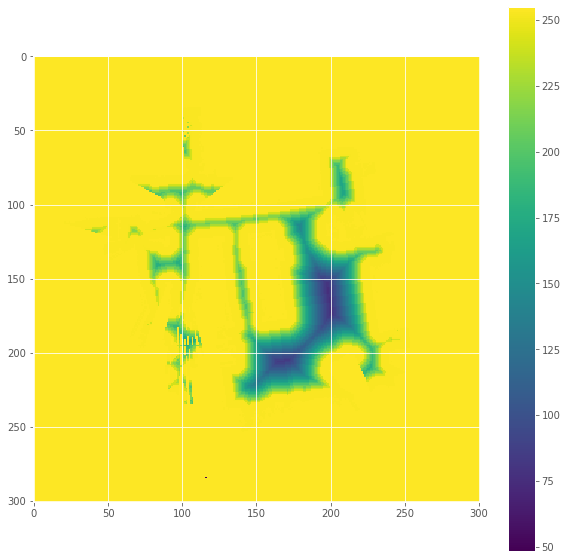

In [46]:
cost_map=numpy.zeros_like(distance_map)
for x_idx in range(map_.shape[0]):
    for y_idx in range(map_.shape[1]):
        cost_map[x_idx,y_idx]=compute_cost(distance_map[x_idx,y_idx])

plt.figure(figsize=(10,10))
plt.imshow(cost_map[100:401,100:401])
plt.colorbar()
plt.show()

In [51]:
%%time
map_ = read_pgm("maps/test_map.pgm", byteorder='<')
costmap=numpy.zeros_like(map_)
for x_idx in range(map_.shape[0]):
    for y_idx in range(map_.shape[1]):
        if map_[x_idx,y_idx]<free_thresh:
            cost_map[x_idx,y_idx]=compute_cost(distance((x_idx,y_idx), map_))

CPU times: user 3.38 s, sys: 0 ns, total: 3.38 s
Wall time: 3.38 s
